<a href="https://colab.research.google.com/github/ykato27/fastai/blob/main/46_tutorial_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 186 kB 5.1 MB/s 
     |████████████████████████████████| 56 kB 3.6 MB/s 


# Collaborative filtering tutorial

> Using the fastai library for collaborative filtering.

In [2]:
from fastai.tabular.all import *
from fastai.collab import *

In [3]:
# all_slow

This tutorial highlights on how to quickly build a `Learner` and train a model on collaborative filtering tasks.

## Training a model

For this tutorial, we will use the [Movielens 100k data dataset](https://grouplens.org/datasets/movielens/100k/). We can download it easily and decompress it with the following function:

In [4]:
path = untar_data(URLs.ML_100k)

The main table is in `u.data`. Since it's not a proper csv, we have to specify a few things while opening it: the tab delimiter, the columns we want to keep and their names.

In [5]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in the table `u.item`:

In [6]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Next we merge it to our ratings table:

In [7]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


We can then build a `DataLoaders` object from this table. By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. We need to change the value of `item_name` in our case, to use the titles instead of the ids:

In [8]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In all applications, when the data has been assembled in a `DataLoaders`, you can have a look at it with the `show_batch` method:

In [9]:
dls.show_batch()

,user,title,rating
0,466,Fallen (1998),4
1,405,"Secret of Roan Inish, The (1994)",1
2,838,Twelfth Night (1996),4
3,372,Kalifornia (1993),5
4,779,Return of the Jedi (1983),5
5,256,Star Trek: The Motion Picture (1979),3
6,849,Twister (1996),5
7,151,Casablanca (1942),5
8,102,Star Trek IV: The Voyage Home (1986),2
9,472,"Nightmare Before Christmas, The (1993)",5


fastai can create and train a collaborative filtering model by using `collab_learner`:

In [10]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

In [11]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.956267,0.937227,00:11
1,0.884609,0.844434,00:11
2,0.727457,0.807804,00:11
3,0.593991,0.794479,00:10
4,0.487352,0.796242,00:10


Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91 (scroll down to the 100k dataset), which corresponds to an MSE of `0.91**2 = 0.83`. So in less than a minute, we got pretty good results!

## Interpretation

Let's analyze the results of our previous model. We will keep the 1000 most rated movies for this:

In [12]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our `top_movies` list with the following command:

In [13]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

Let's compare those biases with the average ratings:

In [14]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Now let's have a look at the movies with the worst bias:

In [15]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3270),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2999),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2623), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2528), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2366), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2276), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2249), 'Escape from L.A. (1996)', 2.4615384615384617),
 (tensor(-0.2239), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2196), "Stephen King's The Langoliers (1995)", 2.413793103448276),
 (tensor(-0.2171), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2111), 'Jungle2Jungle (1997)', 2.4393939393939394),
 (tensor(-0.2111), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2017), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.1998), 'Hellraiser: Bloodline (1996)', 2.0),


Or the ones with the best bias:

In [16]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5832), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5266), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5237), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5232), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5030), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4968), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4919), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4848), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.4829), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.4642), 'North by Northwest (1959)', 4.284916201117318),
 (tensor(0.4634), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4504), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4494), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4243), 'Raiders of the Lost Ark (1981)', 4.252380952380952),
 (tensor(0.4137), 'To Kill a Mockingbird (1962)', 4.292237442922374)]

There is certainly a strong correlation!

### Movie weights

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in `top_movies` the same way as we did for the bias before.

In [17]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

Let's try a PCA to reduce the dimensions and see if we can see what the model learned:

In [18]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [19]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Here are the highest score on the first dimension:

In [20]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2202), 'Children of the Corn: The Gathering (1996)'),
 (tensor(1.2035), 'Flipper (1996)'),
 (tensor(1.1870), "McHale's Navy (1997)"),
 (tensor(1.1020), 'Bio-Dome (1996)'),
 (tensor(1.0857), 'Jungle2Jungle (1997)'),
 (tensor(1.0842), 'Super Mario Bros. (1993)'),
 (tensor(1.0790), 'Leave It to Beaver (1997)'),
 (tensor(1.0299), 'Richie Rich (1994)'),
 (tensor(1.0285), 'Halloween: The Curse of Michael Myers (1995)'),
 (tensor(1.0273), 'Congo (1995)')]

And the worst:

In [21]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1631), 'Close Shave, A (1995)'),
 (tensor(-1.1490), 'Casablanca (1942)'),
 (tensor(-1.0529), 'Godfather, The (1972)'),
 (tensor(-1.0311), 'Lawrence of Arabia (1962)'),
 (tensor(-1.0265), 'Wrong Trousers, The (1993)'),
 (tensor(-1.0195), 'Chinatown (1974)'),
 (tensor(-1.0159), 'Shall We Dance? (1996)'),
 (tensor(-1.0093), 'Citizen Kane (1941)'),
 (tensor(-1.0021),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(-0.9949), 'Cinema Paradiso (1988)')]

Same thing for our second dimension:

In [22]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [23]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1456), 'Braveheart (1995)'),
 (tensor(1.0788), 'Titanic (1997)'),
 (tensor(1.0346), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.9848), 'Independence Day (ID4) (1996)'),
 (tensor(0.8995), 'American President, The (1995)'),
 (tensor(0.8775), 'Forrest Gump (1994)'),
 (tensor(0.8758), "It's a Wonderful Life (1946)"),
 (tensor(0.8512), 'Fugitive, The (1993)'),
 (tensor(0.8107), 'Top Gun (1986)'),
 (tensor(0.8050), 'Back to the Future (1985)')]

In [24]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.9740), 'Sweet Hereafter, The (1997)'),
 (tensor(-0.8716), 'Spice World (1997)'),
 (tensor(-0.8167), 'Jude (1996)'),
 (tensor(-0.8155), 'Gang Related (1997)'),
 (tensor(-0.7781), 'Keys to Tulsa (1997)'),
 (tensor(-0.7729), 'Heavenly Creatures (1994)'),
 (tensor(-0.7715), 'Big Night (1996)'),
 (tensor(-0.7597), 'Boogie Nights (1997)'),
 (tensor(-0.7586), 'Trainspotting (1996)'),
 (tensor(-0.7472), 'Children of the Corn: The Gathering (1996)')]

And we can even plot the movies according to their scores on those dimensions:

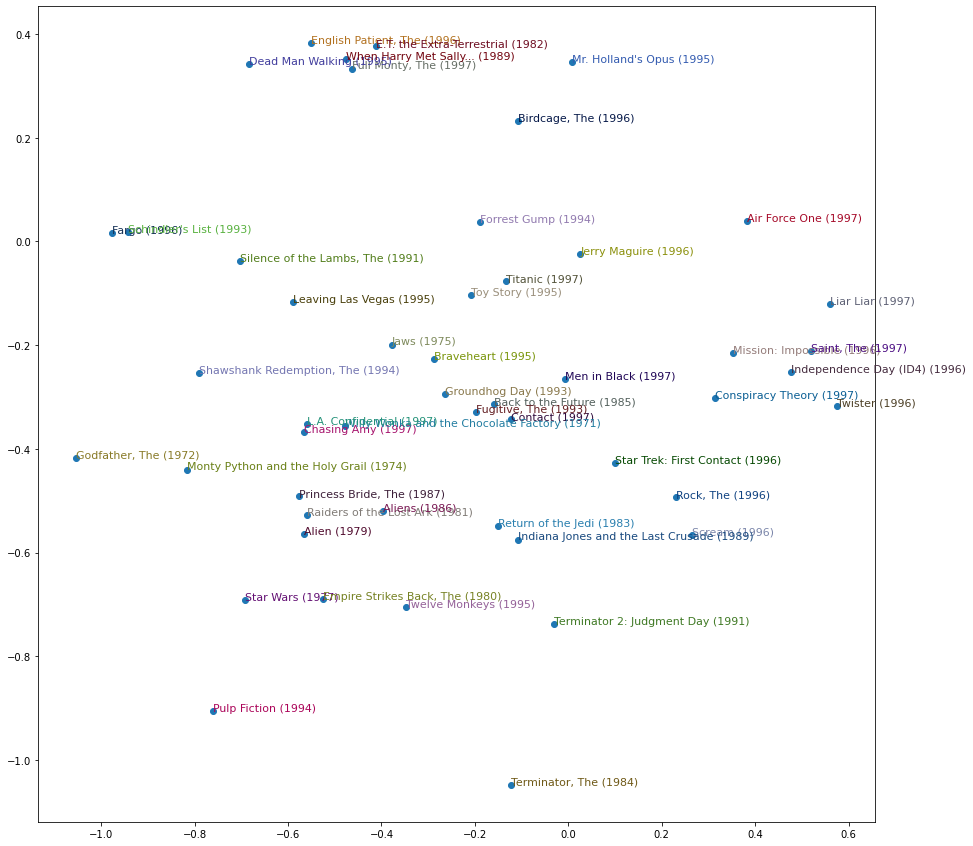

In [25]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()